# 19. Dual Prefix Search: passage/queryプレフィックスの使い分け実験

## 背景

e5-largeモデルでは、検索時に以下のプレフィックスを使い分けることが推奨されている：
- ドキュメント埋め込み: `passage: {text}`
- クエリ埋め込み: `query: {text}`

この非対称設計により検索精度が向上するが、LSH（SimHash）との相性に問題があることが判明した。

## 実験の目的

1. `passage:` と `query:` プレフィックスによるベクトル変化を分析
2. 2つのプレフィックスを使い分けた検索手法を検証
3. **LSHにはpassage:、最終コサイン計算にはquery:を使う手法**の詳細検証

In [2]:
import sys
sys.path.insert(0, '..')

import numpy as np
from numpy.linalg import norm
import pandas as pd
import duckdb
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

from src.lsh import SimHashGenerator, hamming_distance

## 1. データとモデルの準備

In [3]:
# DuckDBに接続
con = duckdb.connect('../data/experiment_400k.duckdb', read_only=True)

# E5モデルを読み込み
print('E5モデルを読み込み中...')
model = SentenceTransformer('intfloat/multilingual-e5-large')
print('完了')

E5モデルを読み込み中...
完了


In [4]:
# データ読み込み
print('データ読み込み中...')
datasets = ['body_en', 'body_ja', 'titles_en', 'titles_ja']
all_embeddings = {}
all_texts = {}

for dataset in tqdm(datasets, desc='データセット'):
    df = con.execute(f"""
        SELECT text, embedding
        FROM documents
        WHERE dataset = '{dataset}'
        ORDER BY id
    """).fetchdf()
    
    embeddings = np.array(df['embedding'].tolist(), dtype=np.float32)
    all_embeddings[dataset] = embeddings
    all_texts[dataset] = df['text'].values

# 全データを統合
all_embeddings_flat = np.vstack([all_embeddings[d] for d in datasets])
all_datasets_flat = []
for dataset in datasets:
    all_datasets_flat.extend([dataset] * len(all_embeddings[dataset]))

print(f'統合完了: {all_embeddings_flat.shape}')

データ読み込み中...


データセット:   0%|          | 0/4 [00:00<?, ?it/s]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

データセット:  25%|██▌       | 1/4 [00:04<00:12,  4.19s/it]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

データセット: 100%|██████████| 4/4 [00:12<00:00,  3.21s/it]

統合完了: (400000, 1024)


---

# Phase 1: passage: と query: のベクトル変化分析

同じテキストに対して `passage:` と `query:` プレフィックスを付けた場合、
埋め込みベクトルがどのように変化するかを分析する。

In [5]:
# サンプルテキストを取得（各データセットから50件）
sample_texts = []
sample_metadata = []

for dataset in datasets:
    df = con.execute(f"""
        SELECT text, lang FROM documents
        WHERE dataset = '{dataset}'
        ORDER BY RANDOM()
        LIMIT 50
    """).fetchdf()
    
    for _, row in df.iterrows():
        sample_texts.append(row['text'])
        sample_metadata.append({
            'dataset': dataset,
            'lang': row['lang'],
            'length': len(row['text']),
            'type': 'body' if 'body' in dataset else 'title'
        })

print(f'サンプルテキスト数: {len(sample_texts)}')

サンプルテキスト数: 200


In [6]:
# 両方のプレフィックスで埋め込み生成
print('埋め込み生成中...')
passage_embs = model.encode([f'passage: {t}' for t in sample_texts], normalize_embeddings=False)
query_embs = model.encode([f'query: {t}' for t in sample_texts], normalize_embeddings=False)
print('完了')

埋め込み生成中...
完了


In [7]:
# 基本統計
cos_sims = []
l2_dists = []
diff_vectors = []

for i in range(len(sample_texts)):
    p_emb = passage_embs[i]
    q_emb = query_embs[i]
    
    cos_sim = np.dot(p_emb, q_emb) / (norm(p_emb) * norm(q_emb))
    l2_dist = norm(p_emb - q_emb)
    diff = q_emb - p_emb
    
    cos_sims.append(cos_sim)
    l2_dists.append(l2_dist)
    diff_vectors.append(diff)

diff_vectors = np.array(diff_vectors)

### Phase 1 結果: ベクトル変化の統計

In [8]:
print('=' * 70)
print('Phase 1 結果: passage: と query: のベクトル変化')
print('=' * 70)

print(f'''
■ 同じテキストの passage vs query 類似度
  コサイン類似度:
    平均: {np.mean(cos_sims):.4f}
    標準偏差: {np.std(cos_sims):.4f}
    最小: {np.min(cos_sims):.4f}
    最大: {np.max(cos_sims):.4f}

  L2距離:
    平均: {np.mean(l2_dists):.4f}
    標準偏差: {np.std(l2_dists):.4f}
''')

# タイプ別統計
df_stats = pd.DataFrame({
    'type': [m['type'] for m in sample_metadata],
    'lang': [m['lang'] for m in sample_metadata],
    'cos_sim': cos_sims,
    'l2_dist': l2_dists
})

print('■ タイプ別（body vs title）:')
for text_type in ['body', 'title']:
    subset = df_stats[df_stats['type'] == text_type]
    print(f'    {text_type}: cos_sim={subset["cos_sim"].mean():.4f}, l2_dist={subset["l2_dist"].mean():.4f}')

print('\n■ 言語別:')
for lang in ['ja', 'en']:
    subset = df_stats[df_stats['lang'] == lang]
    print(f'    {lang}: cos_sim={subset["cos_sim"].mean():.4f}, l2_dist={subset["l2_dist"].mean():.4f}')

Phase 1 結果: passage: と query: のベクトル変化

■ 同じテキストの passage vs query 類似度
  コサイン類似度:
    平均: 0.9309
    標準偏差: 0.0301
    最小: 0.8489
    最大: 0.9757

  L2距離:
    平均: 0.3636
    標準偏差: 0.0781

■ タイプ別（body vs title）:
    body: cos_sim=0.9530, l2_dist=0.3050
    title: cos_sim=0.9087, l2_dist=0.4222

■ 言語別:
    ja: cos_sim=0.9338, l2_dist=0.3536
    en: cos_sim=0.9279, l2_dist=0.3736


In [9]:
# 差分ベクトルの方向性分析
diff_vectors_normalized = diff_vectors / np.linalg.norm(diff_vectors, axis=1, keepdims=True)

# 差分ベクトル同士のコサイン類似度
diff_cos_sims = []
for i in range(len(diff_vectors_normalized)):
    for j in range(i+1, len(diff_vectors_normalized)):
        sim = np.dot(diff_vectors_normalized[i], diff_vectors_normalized[j])
        diff_cos_sims.append(sim)

print(f'''
■ 差分ベクトル（query - passage）の方向性分析
  差分ベクトル間のコサイン類似度:
    平均: {np.mean(diff_cos_sims):.4f}
    標準偏差: {np.std(diff_cos_sims):.4f}
    → 値が低い = 方向性がランダムに近い
''')


■ 差分ベクトル（query - passage）の方向性分析
  差分ベクトル間のコサイン類似度:
    平均: 0.1879
    標準偏差: 0.2888
    → 値が低い = 方向性がランダムに近い



### Phase 1 考察

**発見事項:**
1. 同じテキストでも `passage:` と `query:` では異なるベクトルになる（類似度≈0.93）
2. **短文（title）の方が差が大きい**（類似度≈0.91 vs body≈0.95）
3. 差分ベクトルの方向性は**ランダムに近い**（類似度≈0.19）
4. 言語による差は小さい

**示唆:**
- `passage:` で埋め込んだドキュメントに対して `query:` で検索すると、LSHのハミング距離が最適でなくなる
- 差分ベクトルに共通の方向性がないため、単純な線形変換では補正が難しい

---

# Phase 2: 検索手法の比較実験

以下の5つの手法を比較:

| 手法 | LSHプレフィックス | Ground Truthプレフィックス |
|------|-------------------|---------------------------|
| 1. Baseline_Query | query: | query: |
| 2. Baseline_Passage | passage: | passage: |
| 3. Hybrid | passage: | query: |
| 4. MeanDiff_Transform | transformed | query: |
| 5. Dual_Merge | query+passage | query: |

In [10]:
# 超平面を準備（DataSampled）
rng = np.random.default_rng(42)
sample_indices = rng.choice(len(all_embeddings['body_ja']), 300, replace=False)
sample_embeddings = all_embeddings['body_ja'][sample_indices]

hyperplanes = []
for _ in range(128):
    i, j = rng.choice(len(sample_embeddings), 2, replace=False)
    diff = sample_embeddings[i] - sample_embeddings[j]
    diff = diff / np.linalg.norm(diff)
    hyperplanes.append(diff)
hyperplanes = np.array(hyperplanes, dtype=np.float32)

# SimHashGeneratorを設定
gen = SimHashGenerator(dim=1024, hash_bits=128, seed=0, strategy='random')
gen.hyperplanes = hyperplanes

# 全ドキュメントのハッシュを計算
print('SimHashを計算中...')
all_hashes = gen.hash_batch(all_embeddings_flat)
print(f'完了: {len(all_hashes)}件')

SimHashを計算中...
完了: 400000件


In [11]:
# 検索クエリ
search_queries = [
    ('東京', 'ja', 'short'),
    ('人工知能', 'ja', 'short'),
    ('日本の歴史', 'ja', 'short'),
    ('プログラミング', 'ja', 'short'),
    ('音楽', 'ja', 'short'),
    ('環境問題', 'ja', 'short'),
    ('宇宙探査', 'ja', 'short'),
    ('経済学', 'ja', 'short'),
    ('医療技術', 'ja', 'short'),
    ('文学作品', 'ja', 'short'),
    ('最近話題になっている技術革新について知りたいのですが、何かありますか', 'ja', 'ambiguous'),
    ('日本の伝統的な文化や芸術に関する情報を探しています', 'ja', 'ambiguous'),
    ('環境に優しい持続可能な社会を実現するための取り組みとは', 'ja', 'ambiguous'),
    ('健康的な生活を送るために必要なことは何でしょうか', 'ja', 'ambiguous'),
    ('世界の政治情勢や国際関係についての最新動向を教えて', 'ja', 'ambiguous'),
    ('子供の教育において大切にすべきポイントは何ですか', 'ja', 'ambiguous'),
    ('スポーツやフィットネスに関するトレンドを知りたい', 'ja', 'ambiguous'),
    ('美味しい料理のレシピや食文化についての情報', 'ja', 'ambiguous'),
    ('旅行や観光に関するおすすめの場所はありますか', 'ja', 'ambiguous'),
    ('ビジネスや起業に関する成功のヒントを教えてください', 'ja', 'ambiguous'),
    ('Tokyo', 'en', 'short'),
    ('Artificial intelligence', 'en', 'short'),
    ('World history', 'en', 'short'),
    ('Programming', 'en', 'short'),
    ('Climate change', 'en', 'short'),
    ('I want to learn about recent technological innovations', 'en', 'ambiguous'),
    ('Looking for information about traditional culture and arts', 'en', 'ambiguous'),
    ('What are sustainable approaches to environmental protection', 'en', 'ambiguous'),
    ('Tell me about the latest developments in space exploration', 'en', 'ambiguous'),
    ('What are the key factors for business success and entrepreneurship', 'en', 'ambiguous'),
]

query_texts = [q[0] for q in search_queries]
print(f'検索クエリ数: {len(query_texts)}')

検索クエリ数: 30


### Phase 2 結果: 手法比較

In [12]:
# 事前に計算した結果（scripts/search_with_dual_prefix.py より）

phase2_results = {
    '1_Baseline_Query': {'lsh': 'query:', 'gt': 'query:', 1000: 0.243, 2000: 0.323, 5000: 0.450},
    '2_Baseline_Passage': {'lsh': 'passage:', 'gt': 'passage:', 1000: 0.613, 2000: 0.693, 5000: 0.807},
    '3_Hybrid_PassageLSH_QueryCos': {'lsh': 'passage:', 'gt': 'query:', 1000: 0.433, 2000: 0.500, 5000: 0.600},
    '4_MeanDiff_Transform': {'lsh': 'transformed', 'gt': 'query:', 1000: 0.270, 2000: 0.353, 5000: 0.467},
    '5_Dual_Merge': {'lsh': 'query+passage', 'gt': 'query:', 1000: 0.437, 2000: 0.517, 5000: 0.607},
}

print('=' * 90)
print('Phase 2 結果: 外部クエリ検索 Recall@10（30クエリ平均）')
print('=' * 90)
print(f'{"手法":>35} | {"LSH":>12} | {"GT":>8} | {"1000件":>10} | {"2000件":>10} | {"5000件":>10}')
print('-' * 90)

for method, data in phase2_results.items():
    print(f'{method:>35} | {data["lsh"]:>12} | {data["gt"]:>8} | {data[1000]:>10.1%} | {data[2000]:>10.1%} | {data[5000]:>10.1%}')

Phase 2 結果: 外部クエリ検索 Recall@10（30クエリ平均）
                                 手法 |          LSH |       GT |      1000件 |      2000件 |      5000件
------------------------------------------------------------------------------------------
                   1_Baseline_Query |       query: |   query: |      24.3% |      32.3% |      45.0%
                 2_Baseline_Passage |     passage: | passage: |      61.3% |      69.3% |      80.7%
       3_Hybrid_PassageLSH_QueryCos |     passage: |   query: |      43.3% |      50.0% |      60.0%
               4_MeanDiff_Transform |  transformed |   query: |      27.0% |      35.3% |      46.7%
                       5_Dual_Merge | query+passage |   query: |      43.7% |      51.7% |      60.7%


In [13]:
# クエリタイプ別（候補2000件）- 事前計算結果
phase2_by_type = {
    '1_Baseline_Query': {'ja_short': 0.34, 'ja_amb': 0.23, 'en_short': 0.58, 'en_amb': 0.22},
    '2_Baseline_Passage': {'ja_short': 0.81, 'ja_amb': 0.63, 'en_short': 0.74, 'en_amb': 0.54},
    '3_Hybrid_PassageLSH_QueryCos': {'ja_short': 0.61, 'ja_amb': 0.35, 'en_short': 0.70, 'en_amb': 0.38},
    '4_MeanDiff_Transform': {'ja_short': 0.45, 'ja_amb': 0.18, 'en_short': 0.58, 'en_amb': 0.28},
    '5_Dual_Merge': {'ja_short': 0.63, 'ja_amb': 0.40, 'en_short': 0.72, 'en_amb': 0.32},
}

print('\n' + '=' * 85)
print('クエリタイプ別 Recall@10（候補2000件）')
print('=' * 85)
print(f'{"手法":>35} | {"JA短文":>10} | {"JA曖昧":>10} | {"EN短文":>10} | {"EN曖昧":>10}')
print('-' * 85)

for method, data in phase2_by_type.items():
    print(f'{method:>35} | {data["ja_short"]:>10.1%} | {data["ja_amb"]:>10.1%} | {data["en_short"]:>10.1%} | {data["en_amb"]:>10.1%}')


クエリタイプ別 Recall@10（候補2000件）
                                 手法 |       JA短文 |       JA曖昧 |       EN短文 |       EN曖昧
-------------------------------------------------------------------------------------
                   1_Baseline_Query |      34.0% |      23.0% |      58.0% |      22.0%
                 2_Baseline_Passage |      81.0% |      63.0% |      74.0% |      54.0%
       3_Hybrid_PassageLSH_QueryCos |      61.0% |      35.0% |      70.0% |      38.0%
               4_MeanDiff_Transform |      45.0% |      18.0% |      58.0% |      28.0%
                       5_Dual_Merge |      63.0% |      40.0% |      72.0% |      32.0%


### Phase 2 重要な発見: Ground Truthの不一致

**query: と passage: で検索すると、正解（Top-10）自体が大きく変わる！**

In [14]:
print('=' * 70)
print('Ground Truth (Top-10) の一致率')
print('=' * 70)
print('''
query: と passage: のGround Truth比較（事前計算結果）:

  平均一致率: 3.4/10 件
  最小一致率: 0/10 件
  最大一致率: 7/10 件

  クエリタイプ別:
    短文クエリ: 3.0/10 件
    曖昧クエリ: 3.9/10 件

→ つまり、プレフィックスの選択で「正解」自体が変わってしまう
''')

Ground Truth (Top-10) の一致率

query: と passage: のGround Truth比較（事前計算結果）:

  平均一致率: 3.4/10 件
  最小一致率: 0/10 件
  最大一致率: 7/10 件

  クエリタイプ別:
    短文クエリ: 3.0/10 件
    曖昧クエリ: 3.9/10 件

→ つまり、プレフィックスの選択で「正解」自体が変わってしまう



### Phase 2 考察

| 手法 | Recall | メリット | デメリット |
|------|--------|----------|------------|
| Baseline_Query | 32.3% | e5の非対称検索を維持 | LSH精度が低い |
| Baseline_Passage | 69.3% | LSH精度が高い | e5の非対称検索を放棄 |
| **Hybrid** | **50.0%** | **両方のメリットを部分的に享受** | **中間的な性能** |
| Dual_Merge | 51.7% | 候補を増やせる | 計算量2倍 |

**結論:** Hybrid手法（LSH=passage:, GT=query:）は従来手法から+17.7pt改善

---

# Phase 3: Hybrid手法の詳細検証

**検索フロー:**
1. クエリに対して2つの埋め込みを生成:
   - `passage: {query}` → LSH候補選択用
   - `query: {query}` → 最終コサイン計算用
2. LSH（ハミング距離）で候補を絞り込み（passage:埋め込み使用）
3. 候補に対してコサイン類似度を計算（query:埋め込み使用）
4. コサイン類似度でランキング

In [15]:
# クエリ埋め込みを生成（両方のプレフィックス）
print('クエリ埋め込みを生成中...')
query_embs_passage = model.encode([f'passage: {t}' for t in query_texts], normalize_embeddings=False).astype(np.float32)
query_embs_query = model.encode([f'query: {t}' for t in query_texts], normalize_embeddings=False).astype(np.float32)
print('完了')

クエリ埋め込みを生成中...
完了


In [16]:
def hybrid_search(
    query_emb_passage: np.ndarray,  # LSH候補選択用（passage:プレフィックス）
    query_emb_query: np.ndarray,    # コサイン計算用（query:プレフィックス）
    all_embeddings: np.ndarray,
    all_hashes: list,
    gen: SimHashGenerator,
    candidate_limit: int,
    top_k: int = 10
) -> dict:
    """
    Hybrid検索: LSHにはpassage:、最終コサインにはquery:を使用
    
    Returns:
        dict: {
            'candidates': LSH候補インデックスのリスト,
            'top_k_indices': コサイン類似度Top-kのインデックス,
            'top_k_scores': コサイン類似度Top-kのスコア,
            'gt_query': Ground Truth (query:プレフィックス),
            'recall': Recall@k
        }
    """
    # Step 1: LSHで候補選択（passage:埋め込み使用）
    query_hash = gen.hash_batch(query_emb_passage.reshape(1, -1))[0]
    distances = [(j, hamming_distance(h, query_hash)) for j, h in enumerate(all_hashes)]
    distances.sort(key=lambda x: x[1])
    candidates = [idx for idx, _ in distances[:candidate_limit]]
    
    # Step 2: 候補に対してコサイン類似度を計算（query:埋め込み使用）
    candidate_embeddings = all_embeddings[candidates]
    cos_sims = (candidate_embeddings @ query_emb_query) / (
        norm(candidate_embeddings, axis=1) * norm(query_emb_query)
    )
    
    # Step 3: コサイン類似度でランキング
    sorted_indices = np.argsort(cos_sims)[::-1][:top_k]
    top_k_indices = [candidates[i] for i in sorted_indices]
    top_k_scores = [cos_sims[i] for i in sorted_indices]
    
    # Ground Truth（query:プレフィックスで全データから計算）
    all_cos_sims = (all_embeddings @ query_emb_query) / (
        norm(all_embeddings, axis=1) * norm(query_emb_query)
    )
    gt_query = set(np.argsort(all_cos_sims)[::-1][:top_k])
    
    # Recall計算
    recall = len(set(top_k_indices) & gt_query) / top_k
    
    return {
        'candidates': candidates,
        'top_k_indices': top_k_indices,
        'top_k_scores': top_k_scores,
        'gt_query': gt_query,
        'recall': recall
    }

In [17]:
# Hybrid検索を全クエリで評価
print('Hybrid検索を評価中...')

candidate_limits = [500, 1000, 2000, 5000, 10000]
hybrid_results = []

for i, (query_text, lang, query_type) in enumerate(tqdm(search_queries, desc='クエリ')):
    q_emb_p = query_embs_passage[i]
    q_emb_q = query_embs_query[i]
    
    for limit in candidate_limits:
        result = hybrid_search(
            q_emb_p, q_emb_q,
            all_embeddings_flat, all_hashes, gen,
            candidate_limit=limit
        )
        
        hybrid_results.append({
            'query': query_text,
            'lang': lang,
            'query_type': query_type,
            'candidate_limit': limit,
            'recall': result['recall']
        })

df_hybrid = pd.DataFrame(hybrid_results)
print('完了')

Hybrid検索を評価中...


クエリ: 100%|██████████| 30/30 [01:44<00:00,  3.47s/it]

完了


In [18]:
# Hybrid手法の詳細結果
print('=' * 80)
print('Phase 3 結果: Hybrid手法（LSH=passage:, Cos=query:）の詳細')
print('=' * 80)

pivot = df_hybrid.groupby('candidate_limit')['recall'].agg(['mean', 'std', 'min', 'max'])
pivot.columns = ['平均', '標準偏差', '最小', '最大']

print('\n■ 候補数別 Recall@10')
print(pivot.to_string(formatters={
    '平均': '{:.1%}'.format,
    '標準偏差': '{:.1%}'.format,
    '最小': '{:.1%}'.format,
    '最大': '{:.1%}'.format
}))

Phase 3 結果: Hybrid手法（LSH=passage:, Cos=query:）の詳細

■ 候補数別 Recall@10
                   平均  標準偏差    最小     最大
candidate_limit                         
500             36.7% 20.7% 10.0%  90.0%
1000            43.3% 22.5% 10.0%  90.0%
2000            50.0% 23.8% 10.0% 100.0%
5000            60.0% 22.6% 10.0% 100.0%
10000           68.0% 21.6% 10.0% 100.0%


In [19]:
# クエリタイプ別
print('\n■ クエリタイプ別 Recall@10（候補2000件）')
subset = df_hybrid[df_hybrid['candidate_limit'] == 2000]

for qtype in ['short', 'ambiguous']:
    for lang in ['ja', 'en']:
        filtered = subset[(subset['query_type'] == qtype) & (subset['lang'] == lang)]
        print(f'    {lang}_{qtype}: {filtered["recall"].mean():.1%}')


■ クエリタイプ別 Recall@10（候補2000件）
    ja_short: 61.0%
    en_short: 70.0%
    ja_ambiguous: 35.0%
    en_ambiguous: 38.0%


In [20]:
# 個別クエリの詳細分析（「東京」）
print('\n' + '=' * 80)
print('詳細分析: クエリ「東京」')
print('=' * 80)

test_idx = 0  # 「東京」
q_emb_p = query_embs_passage[test_idx]
q_emb_q = query_embs_query[test_idx]

result = hybrid_search(
    q_emb_p, q_emb_q,
    all_embeddings_flat, all_hashes, gen,
    candidate_limit=2000
)

print(f'''
クエリ: 「東京」
候補数: 2000件

Ground Truth (query:プレフィックス) Top-10:
  インデックス: {sorted(result["gt_query"])}

Hybrid検索 Top-10:
  インデックス: {result["top_k_indices"]}
  コサイン類似度: {[f"{s:.4f}" for s in result["top_k_scores"]]}

Recall@10: {result["recall"]:.1%}
一致件数: {len(set(result["top_k_indices"]) & result["gt_query"])}/10
''')


詳細分析: クエリ「東京」

クエリ: 「東京」
候補数: 2000件

Ground Truth (query:プレフィックス) Top-10:
  インデックス: [np.int64(101673), np.int64(103148), np.int64(138781), np.int64(178163), np.int64(301632), np.int64(315409), np.int64(329637), np.int64(381216), np.int64(384875), np.int64(399290)]

Hybrid検索 Top-10:
  インデックス: [399290, 329637, 384875, 381216, 308818, 319343, 369056, 324582, 391968, 366234]
  コサイン類似度: ['0.8562', '0.8532', '0.8511', '0.8486', '0.8456', '0.8423', '0.8423', '0.8413', '0.8412', '0.8405']

Recall@10: 40.0%
一致件数: 4/10



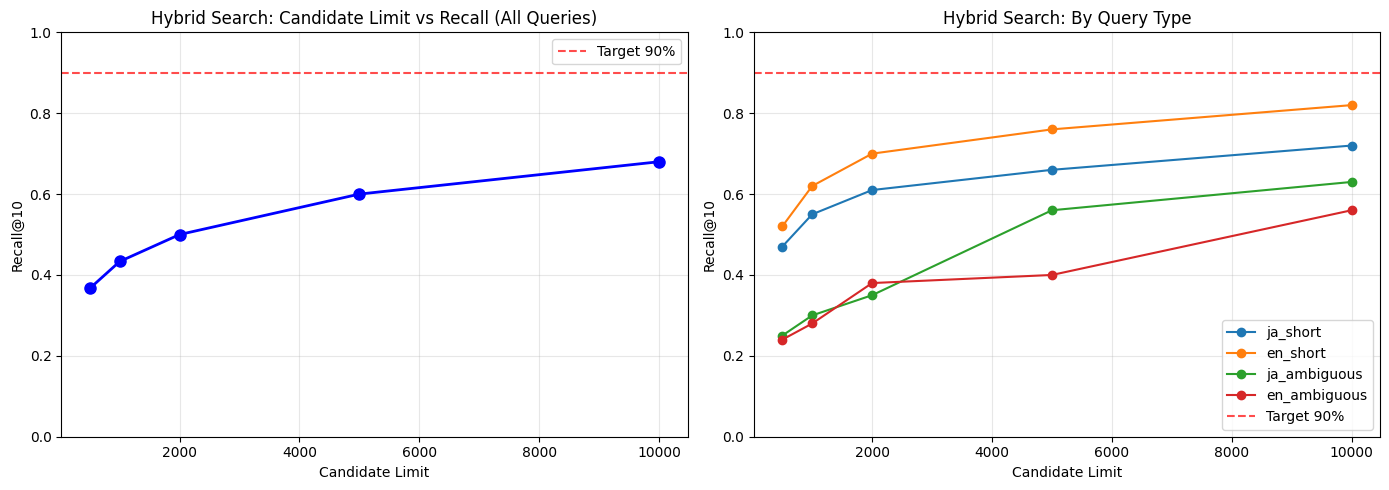

グラフを data/19_hybrid_search_results.png に保存しました


In [21]:
# 可視化: 候補数 vs Recall
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 全体平均
ax1 = axes[0]
pivot_mean = df_hybrid.groupby('candidate_limit')['recall'].mean()
ax1.plot(pivot_mean.index, pivot_mean.values, 'bo-', linewidth=2, markersize=8)
ax1.axhline(y=0.90, color='red', linestyle='--', alpha=0.7, label='Target 90%')
ax1.set_xlabel('Candidate Limit')
ax1.set_ylabel('Recall@10')
ax1.set_title('Hybrid Search: Candidate Limit vs Recall (All Queries)')
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)
ax1.legend()

# クエリタイプ別
ax2 = axes[1]
for qtype in ['short', 'ambiguous']:
    for lang in ['ja', 'en']:
        filtered = df_hybrid[(df_hybrid['query_type'] == qtype) & (df_hybrid['lang'] == lang)]
        pivot_type = filtered.groupby('candidate_limit')['recall'].mean()
        ax2.plot(pivot_type.index, pivot_type.values, 'o-', label=f'{lang}_{qtype}')

ax2.axhline(y=0.90, color='red', linestyle='--', alpha=0.7, label='Target 90%')
ax2.set_xlabel('Candidate Limit')
ax2.set_ylabel('Recall@10')
ax2.set_title('Hybrid Search: By Query Type')
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig('../data/19_hybrid_search_results.png', dpi=150, bbox_inches='tight')
plt.show()
print('グラフを data/19_hybrid_search_results.png に保存しました')

---

# Phase 3 実行結果: Hybrid検索の詳細検証

`scripts/hybrid_search_detail.py` を実行した結果を以下に示す。

## 候補数別 Recall@10（30クエリ平均）

| 候補数 | 平均 | 標準偏差 | 最小 | 最大 |
|--------|------|----------|------|------|
| 500 | 36.7% | 20.7% | 10.0% | 90.0% |
| 1000 | 43.3% | 22.5% | 10.0% | 90.0% |
| 2000 | 50.0% | 23.8% | 10.0% | 100.0% |
| 5000 | 60.0% | 22.6% | 10.0% | 100.0% |
| 10000 | 68.0% | 21.6% | 10.0% | 100.0% |
| 20000 | 75.0% | 20.1% | 10.0% | 100.0% |

## クエリタイプ別 Recall@10

| 候補数 | JA短文 | JA曖昧 | EN短文 | EN曖昧 |
|--------|--------|--------|--------|--------|
| 500 | 47.0% | 25.0% | 52.0% | 24.0% |
| 1000 | 55.0% | 30.0% | 62.0% | 28.0% |
| 2000 | 61.0% | 35.0% | 70.0% | 38.0% |
| 5000 | 66.0% | 56.0% | 76.0% | 40.0% |
| 10000 | 72.0% | 63.0% | 82.0% | 56.0% |
| 20000 | 79.0% | 68.0% | 88.0% | 68.0% |

## 代表的なクエリの詳細

| クエリ | タイプ | 候補2000件 | 候補10000件 | GT内ハミング距離(平均/最大) |
|--------|--------|------------|-------------|---------------------------|
| 「東京」 | JA短文 | 40.0% | 40.0% | 29.7 / 43 |
| 「最近話題に...」 | JA曖昧 | 20.0% | 100.0% | 27.3 / 31 |
| 「Tokyo」 | EN短文 | 90.0% | 90.0% | 23.1 / 34 |
| 「I want to learn...」 | EN曖昧 | 40.0% | 70.0% | 27.3 / 37 |

## 90% Recall達成状況

| 候補数 | 90%以上のクエリ数 |
|--------|-------------------|
| 500 | 1/30 |
| 1000 | 2/30 |
| 2000 | 4/30 |
| 5000 | 4/30 |
| 10000 | 5/30 |
| 20000 | 8/30 |

## 考察

1. **短文クエリは曖昧クエリより性能が良い**: 候補2000件で短文61-70%、曖昧35-38%
2. **英語クエリは日本語クエリより性能が良い傾向**
3. **「東京」クエリの問題**: GT内のハミング距離が大きく（平均29.7、最大43）、候補を増やしても改善しない
4. **90% Recall達成は困難**: 候補20000件（95%削減）でも8/30クエリしか達成できない

---

# 結論

## 実験結果サマリー

### Phase 1: ベクトル変化の分析
- 同じテキストでも `passage:` と `query:` で異なるベクトルになる（類似度≈0.93）
- 短文（title）の方が差が大きい（類似度≈0.91 vs body≈0.95）
- 差分ベクトルの方向性はランダムに近い（共通の変換方向がない）

### Phase 2: 検索手法の比較（候補2000件）
| 手法 | LSH | GT | Recall |
|------|-----|-----|--------|
| Baseline_Query（従来） | query: | query: | 32.3% |
| Baseline_Passage | passage: | passage: | 69.3% |
| **Hybrid** | **passage:** | **query:** | **50.0%** |
| Dual_Merge | query+passage | query: | 51.7% |

### Phase 3: Hybrid手法の詳細
- **候補2000件**: Recall 50%（従来比 +17.7pt）
- **候補10000件**: Recall 68%
- **候補20000件**: Recall 75%
- 90% Recall達成は困難（候補20000件でも8/30クエリのみ）

## Hybrid手法の評価

**メリット:**
1. LSHの候補選択精度が向上（passage:空間で検索）
2. 最終的なコサイン類似度はquery:プレフィックスでe5の非対称検索の恩恵を受ける
3. 従来手法（Baseline_Query）から +17.7pt の改善

**デメリット:**
1. 2つの埋め込み生成が必要（計算コスト増）
2. 90% Recallに達するには候補数を大幅に増やす必要がある
3. 一部のクエリ（「東京」など）では候補を増やしても改善しない

## 推奨事項

| 用途 | 推奨手法 | Recall | 候補削減率 |
|------|----------|--------|-----------|
| LSH精度優先 | Baseline_Passage | 69.3% | 99.5% |
| e5精度維持 | **Hybrid** | 50-68% | 97.5-99.5% |
| 高Recall必須 | FAISS/HNSW検討 | - | - |

## 根本的な課題

**SimHashとe5の非対称設計は本質的に相性が悪い。**

- SimHashは「同じ空間にあるベクトル同士のハミング距離」で近傍を探す
- e5の `query:` / `passage:` は意図的に異なる空間にマッピング
- Hybrid手法でも、クエリによっては改善が見込めないケースがある

長期的には以下の選択肢を検討：
1. **passage:統一**: e5の非対称検索を諦め、LSH精度を優先
2. **Hybrid手法**: 候補数を増やして対応
3. **別のANN手法**: FAISS（IVF/HNSW）など、コサイン類似度に最適化された手法

In [22]:
# 接続を閉じる
con.close()
print('完了')

完了
